In [1]:
import pickle

import sys
sys.path.insert(0, 'src') 
sys.path.insert(0, '/data/ch52669/gene_interaction/tot-gene-sets/MedAgents') 
import os
import json
from functools import partial

import seaborn as sns

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import torch
from scipy.stats import pearsonr, spearmanr

    
SapBERT_tokenizer = AutoTokenizer.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')
SapBERT_model = AutoModel.from_pretrained('cambridgeltl/SapBERT-from-PubMedBERT-fulltext')

In [101]:
data_size = 50

with open('results2/tot_eval_uncertainty_5steps_abla_uncertain_False.pkl', 'rb') as f:
    tot_results_gpt3_abla = pickle.load(f)
    tot_results_gpt3_abla = tot_results_gpt3_abla[:data_size]
    print(len(tot_results_gpt3_abla))
    

with open('results2/tot_eval_uncertainty_5steps_3.pkl', 'rb') as f:
    tot_results_gpt3 = pickle.load(f)
    tot_results_gpt3 = tot_results_gpt3[:data_size]
    print(len(tot_results_gpt3))
    
with open('results2/tot_eval_uncertainty_5steps_abla_uncertain_False_th08.pkl', 'rb') as f:
    tot_results_gpt3_abla08 = pickle.load(f)
    tot_results_gpt3_abla08 = tot_results_gpt3_abla08[:data_size]
    print(len(tot_results_gpt3_abla08))
    
with open('results2/tot_eval_uncertainty_5steps_abla_uncertain_False_th05.pkl', 'rb') as f:
    tot_results_gpt3_abla05 = pickle.load(f)
    tot_results_gpt3_abla05 = tot_results_gpt3_abla05[26:30] + tot_results_gpt3_abla05[:25] #+ tot_results_gpt3_abla05[32:]
    print(len(tot_results_gpt3_abla05))
    
with open('results2/tot_eval_uncertainty_5steps_abla_uncertain_False_th098.pkl', 'rb') as f:
    tot_results_gpt3_abla098 = pickle.load(f)
    tot_results_gpt3_abla098 = tot_results_gpt3_abla098[:data_size]
    print(len(tot_results_gpt3_abla098))

with open('results2/tot_eval_uncertainty_5steps_15gen_th09.pkl', 'rb') as f:
    tot_results_abla_15gen_th09 = pickle.load(f)
    tot_results_abla_15gen_th09 = tot_results_abla_15gen_th09[:data_size]
    print(len(tot_results_abla_15gen_th09))

50
50
50
29
43
29


In [102]:
for i in tot_results_gpt3_abla098:
    print(i['index'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
28
29
30
31
32
33
34
35
36
37
38
39
40
41


In [37]:
def getSentenceEmbedding(sentence, tokenizer, model):
    # Tokenize sentences
    encoded_input = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
        
    # Perform pooling. In this case, mean pooling.
    sentence_embedding = model_output.last_hidden_state.mean(dim=1)#mean_pooling(model_output, encoded_input['attention_mask'])
    
    return sentence_embedding


In [13]:
from tqdm import tqdm_notebook

def process_result(result):
    all_list = []
    for result in tqdm_notebook(result):
        label = result['label']
        name_all_list = {'layer':[], 'label':label}
        for i, t in enumerate(result['steps']['steps']):
            x = t['x']
            if i == len(result['steps']['steps'])-1:
                break
            name_all_list['layer'].append({'names':[]})
            freqeuncy = []
            for item in t['sorted_grouped_items']:
                names = list(item[1])[0]
                names = names.split(', ')
                occur = len(names)
                name = names[0]
                name_all_list['layer'][i]['names'].append(name)
                freqeuncy.append(occur)
            freqeuncy = [f/sum(freqeuncy) for f in freqeuncy]
    #         votes = t['votes']
            values = t['values']
            name_all_list['layer'][i].update({'frequency':freqeuncy})
    #         entropy = normalized_compute_entropy(np.array(freqeuncy))
    #         name_all_list['layer'][i].update({'entropy':entropy})
    #         name_all_list['layer'][i].update({'genes':x})
    #         name_all_list['layer'][i].update({'votes':votes})
            name_all_list['layer'][i].update({'values':values})
        all_list.append(name_all_list)
    return all_list

process_tot_results_gpt3_abla = process_result(tot_results_gpt3_abla)
process_tot_results_gpt3 = process_result(tot_results_gpt3)

/tmp/ipykernel_3614049/3675436393.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for result in tqdm_notebook(result):


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Layer_1
avg sim: 0.35741055755087964
Layer_2
avg sim: 0.41049347147628834
Layer_3
avg sim: 0.4221210677236994
Layer_4
avg sim: 0.4280878739162119
Layer_5
avg sim: 0.41882533007226563


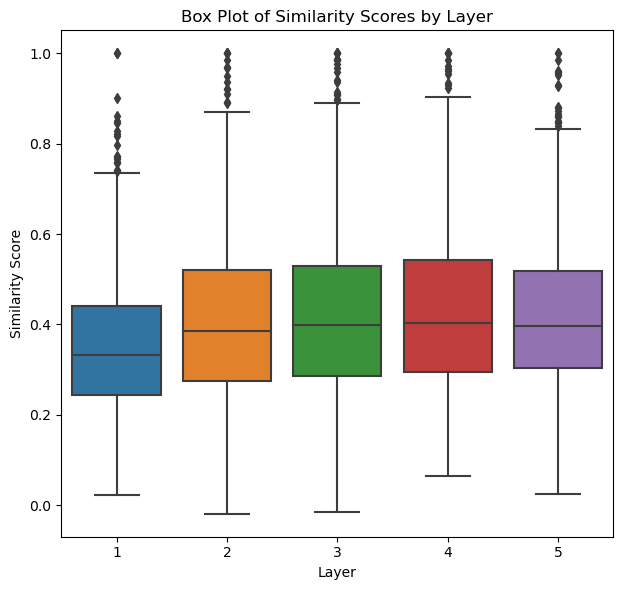


Layer_1
avg sim: 0.3584295341736107
Layer_2
avg sim: 0.4011301269249399
Layer_3
avg sim: 0.42656513144540936
Layer_4
avg sim: 0.4267903152132815
Layer_5
avg sim: 0.4202187155186228


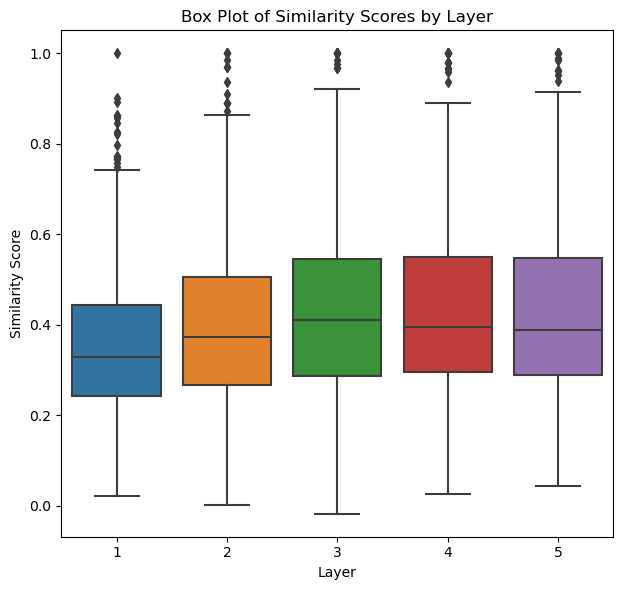

In [20]:
def sim_report(all_list):
    all_sim_list = []
    for i in range(5):
        print(f'Layer_{i+1}')
        list_to_eval = [[],[]]
        for name_all_list in all_list:
            label = name_all_list['label']
        #     for n in name_all_list['layer']:
            n = name_all_list['layer'][i]
            names = n['names']
            name_eval = names + [label]
            # Get embeddings for all items, considering duplicates 
            all_items_embeddings = getSentenceEmbedding(name_eval, SapBERT_tokenizer, SapBERT_model)
            # Calculate cosine similarity between all items
            similarity_matrix = cosine_similarity(all_items_embeddings)[-1][:-1]
            list_to_eval[0].extend(similarity_matrix)
            list_to_eval[1].extend(n['frequency'])
        all_sim_list.append(list_to_eval[0])
        print(f'avg sim: {sum(list_to_eval[0])/len(list_to_eval[0])}')
    plt.figure(figsize=(12, 6))

    # Box plot
    plt.subplot(1, 2, 1)
    sns.boxplot(data=all_sim_list)
    plt.title('Box Plot of Similarity Scores by Layer')
    plt.xlabel('Layer')
    plt.ylabel('Similarity Score')

    plt.xticks([0,1,2,3,4], [1,2,3,4,5])  # Set new labels
    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()
    
sim_report(process_tot_results_gpt3_abla)
print()
sim_report(process_tot_results_gpt3)

In [98]:
import json
# for item1, item2, item3 in [tot_results_gpt3_abla05, tot_results_gpt3_abla08, tot_results_gpt3_abla098]:

def get_layer_sim_among_names(result):
    for k in range(5):
        sims = []
        for item in result:
            i = item['steps']['steps'][k]
            layer_name = []
            for y in i['sorted_grouped_items']:
                first_names = y[1]['grouped_names'].split(', ')[0]
                layer_name.append(first_names)
#             print(layer_name)
            all_items_embeddings = getSentenceEmbedding(layer_name, SapBERT_tokenizer, SapBERT_model)
            # Calculate cosine similarity between all items
            similarity_matrix = cosine_similarity(all_items_embeddings)
            # Calculate the sum of all pairwise similarities, excluding self-comparisons
            sum_of_similarities = np.sum(similarity_matrix) - np.trace(similarity_matrix)
#             print(similarity_matrix)
            # Calculate the number of comparisons (excluding self-comparisons)
            num_comparisons = len(layer_name) * (len(layer_name) - 1)
#             error
            if num_comparisons == 0:
                print('skip')
                continue
            # Calculate the average similarity
            average_similarity = sum_of_similarities / num_comparisons
#             print(average_similarity)
            sims.append(average_similarity)
        print(f'layer: {k+1}, average_similarity: {average_similarity}')
        
        
print('tot_results_gpt3_abla05')
get_layer_sim_among_names(tot_results_gpt3_abla05)
print()            

print('tot_results_gpt3_abla08')
get_layer_sim_among_names(tot_results_gpt3_abla08)
print()

print('tot_results_gpt3_abla098')
get_layer_sim_among_names(tot_results_gpt3_abla098)
print()

print('tot_results_abla_15gen_th09')
get_layer_sim_among_names(tot_results_abla_15gen_th09)
print()

tot_results_gpt3_abla05
skip
skip
skip
skip
layer: 1, average_similarity: 0.4533761143684387
skip
skip
skip
layer: 2, average_similarity: 0.38237088521321616
skip
skip
layer: 3, average_similarity: 0.2649385929107666
skip
skip
layer: 4, average_similarity: 0.3671204249064128
skip
skip
layer: 5, average_similarity: 0.4832983414332072

tot_results_gpt3_abla08
layer: 1, average_similarity: 0.4763530549548921
layer: 2, average_similarity: 0.42401403850979275
layer: 3, average_similarity: 0.5230084525214301
layer: 4, average_similarity: 0.5077494303385417
layer: 5, average_similarity: 0.4286104679107666

tot_results_gpt3_abla098
layer: 1, average_similarity: 0.5103974342346191
layer: 2, average_similarity: 0.5171507321871244
layer: 3, average_similarity: 0.47050966853983917
layer: 4, average_similarity: 0.5689953193462715
layer: 5, average_similarity: 0.517486572265625

tot_results_abla_15gen_th09
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
skip
layer: 1, average_similarity:

In [107]:

import json
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import torch
from collections import Counter, defaultdict
from typing import List
    
import numpy as np

def explore_step_threshold_random_sample(ys_list: List[List[str]], exploration_rate: float=0.1) -> List:
    '''
    ys_list should be an array of num_samples x num_bio_processes (in our case, 3)
    We want do sampling over each column of ys_list, i.e. for each bio_process index
    For each bio process index, with probability exploration_rate, choose a random term from the column;
    with probability 1-exploration_rate, choose the term with the highest frequency
    '''

    num_samples = len(ys_list)
    num_bio_processes = len(ys_list[0])
    results = np.zeros(num_bio_processes)
    for i in range(num_bio_processes):
        bio_process_terms = [ys_list[j][i] for j in range(num_samples)]
        if np.random.rand() < exploration_rate:
            results[i] = np.random.choice(bio_process_terms)
        else:
            results[i] = Counter(bio_process_terms).most_common(1)[0][0]
    return results

ys = [
        [1, 2, 3],
        [1, 2, 3],
        [3, 2, 1],
        [3, 1, 2],
        [2, 1, 3],
      ]
explore_step_threshold_random_sample(ys, 0.0)

array([1., 2., 3.])